In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from skimage.feature import hog, SIFT

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

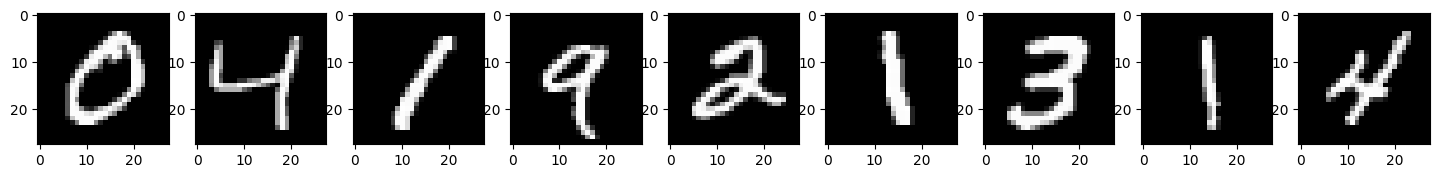

In [ ]:
plt.figure(figsize=(20, 2))
for i in range(1, 10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

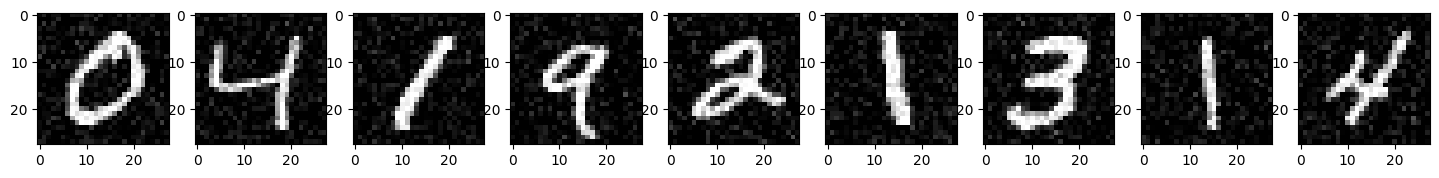

In [ ]:
#Displaying images with noise
plt.figure(figsize=(20, 2))
for i in range(1, 10):
    ax = plt.subplot(1, 10, i)
    plt.imshow(x_train_noisy[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Extract HOG features 
def extract_HOG_features(data):
    num_samples = data.shape[0]
    hog_features = []
    for i in range(num_samples):
        img = data[i]
        feature = hog(img, orientations=4, pixels_per_cell=(3, 3), cells_per_block=(3, 3), block_norm="L2")
        hog_features.append(feature)
    return np.array(hog_features)

In [ ]:
example = np.array([x_train[0]])
example_features = extract_HOG_features(example)
example_features.shape

(1, 1764)

In [ ]:
train_features = extract_HOG_features(x_train_noisy)
test_features = extract_HOG_features(x_test_noisy)

In [ ]:
train_features[0].shape

(1764,)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=train_features[0].shape),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.35),
  tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dropout(0.3),
  # tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(10, activation = 'softmax')
])

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compile model with the loss function of categorical cross entropy 
# Categorical cross entropy is most commonly used for classification problems
model.compile(loss=loss_fn, optimizer="adam", metrics=["accuracy"])
## Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1764)              0         
                                                                 
 dense (Dense)               (None, 512)               903680    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 910,858
Trainable params: 909,834
Non-trainable params: 1,024
______________________________________________

In [ ]:
reduceLearningRate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.0001)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

# Train model with .fit function
history = model.fit(
    train_features,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=100,
    shuffle = True,
    callbacks=[reduceLearningRate, earlyStopping]
)
model.save(r'/content/drive/MyDrive/Machine Learning/ANN_MNIST/Model/HOG_noise_best.h5')

Epoch 1/50
480/480 [==============================] - 2s 4ms/step - loss: 0.0121 - accuracy: 0.9971 - val_loss: 0.0473 - val_accuracy: 0.9860 - lr: 1.0000e-04
Epoch 2/50
480/480 [==============================] - 2s 4ms/step - loss: 0.0106 - accuracy: 0.9976 - val_loss: 0.0474 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 3/50
480/480 [==============================] - 2s 4ms/step - loss: 0.0100 - accuracy: 0.9979 - val_loss: 0.0481 - val_accuracy: 0.9860 - lr: 1.0000e-04
Epoch 4/50
480/480 [==============================] - 2s 4ms/step - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.0476 - val_accuracy: 0.9863 - lr: 1.0000e-04


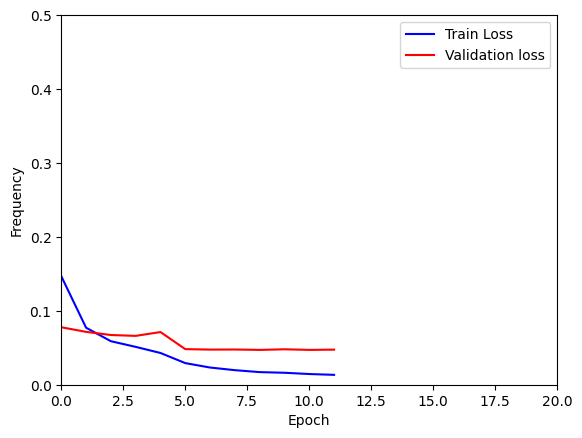

In [ ]:
## Plot loss and val_loss frequency in each epoch 
plt.plot(history.history["loss"], 'b', label="Train Loss")
plt.plot(history.history["val_loss"], 'r', label="Validation loss")
plt.axis([0, 20, 0, 0.5])
plt.xlabel("Epoch")
plt.ylabel("Frequency")
plt.legend()
plt.show()
plt.style.use('default')

313/313 [==============================] - 1s 2ms/step


<Axes: xlabel='Predict', ylabel='Actual'>

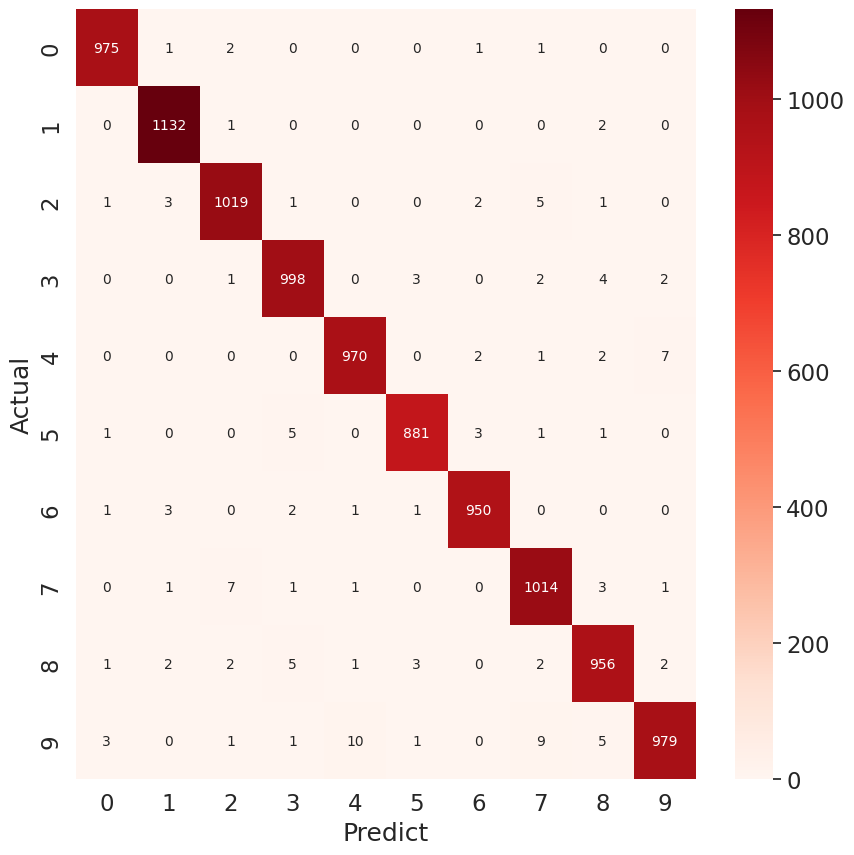

In [ ]:
predictions = model.predict(test_features)
actual = y_test
# Pass testLabels and predictions to confusion matrix
matrix = metrics.confusion_matrix(
    actual,
    np.argmax(predictions, axis = 1)
)
# Plot confusion matrix with matplotlib
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

DataFrameMatrix = pd.DataFrame(matrix, columns=np.unique(labels), index = np.unique(labels))
DataFrameMatrix.index.name = 'Actual'
DataFrameMatrix.columns.name = 'Predict'
plt.figure(figsize = (10,10))
sn.set(font_scale=1.5) 
sn.heatmap(DataFrameMatrix, cmap="Reds", annot=True, annot_kws={"size": 10}, fmt="d")

In [ ]:
print(metrics.classification_report(actual, np.argmax(predictions, axis = 1), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
print(metrics.accuracy_score(actual, np.argmax(predictions, axis = 1)))

0.9874
